# Análisis exploratorio - ZonaProp

### Cargamos las librerias a utilizar.

In [29]:
%matplotlib inline
import pandas as pd # Trabajo de Dataframes
import seaborn as sns # Trabajo con plots estadisticos
import numpy as np # Trabajo con matrices
import matplotlib.pyplot as plt # Plots mas simples
import geopandas as gpd
import cartopy.io.shapereader as shapereader
import geopandas


#### Definimos algunas funciones que nos van a resultar útiles más adelante

In [30]:
def memory(df):
    memory = (df.memory_usage()/(1024*1024)).sum().round(2)
    return memory

#### Levantamos el Dataset

In [31]:
# Ojo la carpeta donde se guarda.
df = pd.read_csv('data/train.csv', index_col=['id'], parse_dates=['fecha'], error_bad_lines=False)

In [32]:
#Una manera prolija de ver rapidamente las columnas y un ejemplo de los datos en ellas.
#df.head().transpose()

In [33]:
# Usar el id como index no es muy practico.
df.reset_index(inplace=True)

In [34]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

### Compruebo la cantidad de NaN/Nulls que hay en cada columna del dataset

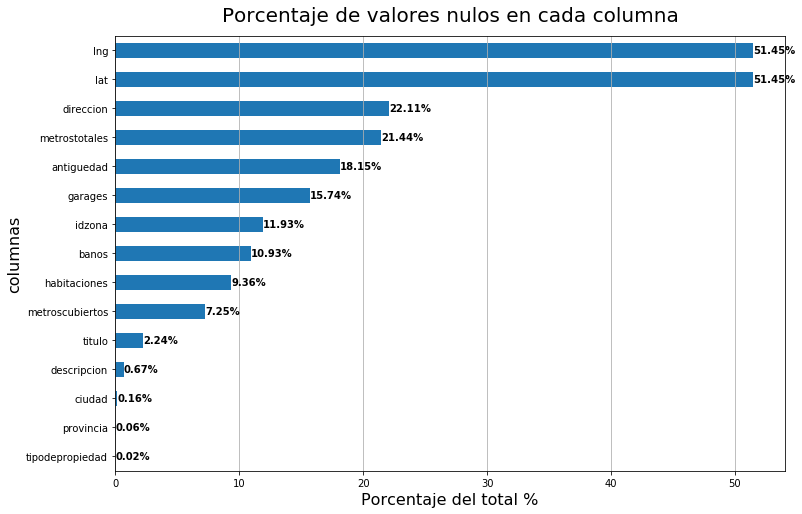

In [35]:
# Hay que ponerlo un poco más bonito pero me parece que ya cumple su función.
nulls = pd.DataFrame((df.isnull().sum().sort_values()/len(df)*100).round(2),columns=['porcentaje de NaN'])
nulls.drop(nulls.loc[nulls.loc[:,'porcentaje de NaN']<=0].index, inplace=True)
plt.figure(figsize=(12,8))
ax = nulls['porcentaje de NaN'].plot.barh()
ax.set_title('Porcentaje de valores nulos en cada columna',fontsize=20, y=1.02)
ax.set_xlabel('Porcentaje del total %', fontsize=16)
ax.set_ylabel('columnas', fontsize=16)
ax.grid(axis='x')

for y, x in enumerate(nulls['porcentaje de NaN']):
    ax.text(x, y, s=str(x)+'%', color='black', fontweight='bold',va='center')
    
#plt.savefig('images/nulls.png')


#### Del gráfico anterior, vemos que hay varias columnas con un porcentaje muy bajo de NaN. Los eliminamos porque son irrelevantes

In [36]:
df.dropna(subset=['tipodepropiedad','provincia','ciudad'],inplace=True)


## Optimización del DataFrame

#### Vemos cuanta memoria ocupa nuestro dataframe antes de la optimización

In [37]:
print('El dataframe ocupa: ',memory(df),'MB.', 'Tiene {} filas'.format(df.shape[0]), 'y {} columnas.'.format(df.shape[1]))


El dataframe ocupa:  43.87 MB. Tiene 239600 filas y 23 columnas.


#### Revisamos los dtypes y casteamos los que no sean adecuados

In [38]:
df.dtypes

id                                     int64
titulo                                object
descripcion                           object
tipodepropiedad                       object
direccion                             object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
idzona                               float64
lat                                  float64
lng                                  float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio    

In [39]:
a = df.get_dtype_counts()
a
print('El data frame tiene {} dtypes float64,'.format(a[0]),
     a[1],'del tipo datetime64','y {}'.format(a[2]),'del tipo object.')


El data frame tiene 15 dtypes float64, 1 del tipo datetime64 y 6 del tipo object.


/home/pintopicada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `get_dtype_counts` has been deprecated and will be removed in a future version. For DataFrames use `.dtypes.value_counts()
  """Entry point for launching an IPython kernel.


#### Sospechamos que hay varias columnas que tienen dtype:float64 pero en realudad son booleanos. Comprombamos viendo si tienen solo dos valores únicos: 0 y 1.

In [40]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())
print("Valores únicos gym: ", df.gimnasio.unique())

Valores únicos piscina:  [0. 1.]
Valores únicos usos multiples:  [0. 1.]
Valores únicos escuelas cercanas:  [0. 1.]
Valores únicos centros comerciales cercanos:  [0. 1.]
Valores únicos gym:  [0. 1.]


#### Sospechamos que hay varias columnas que tienen dtype:float64 pero los valores que pueden tomar son del tipo entero. Comprobamos viendo los todos los posibles valores que toma cada columna

In [41]:
print("Valores únicos baños: ", df.banos.unique())
print("Valores únicos habitaciones: ", df.habitaciones.unique())
print("Valores únicos garages: ", df.garages.unique())


Valores únicos baños:  [ 2.  1.  3. nan  4.]
Valores únicos habitaciones:  [ 2.  3.  4. nan  5.  1.  9.  7. 10.  6.  8.]
Valores únicos garages:  [ 1.  2. nan  0.  3.]


#### Casteamos usando el método astype

In [42]:
# Como castear campos bool a int 16
df = df.astype({
    "piscina": 'int16', "usosmultiples": 'int16', "escuelascercanas": 'int16',
    "centroscomercialescercanos": 'int16', "gimnasio":'int16'})
# Baños, habitaciones y garages como ya comprobamos también hay que castearlos a int16 pero no se puede mientras hayan NaN.

In [43]:
memory(df) # Hemos disminuido en aproximadamente un 20% el tamaño

37.02

### Agrego una columna con el valor de la propiedad en dolares estadounidenses.

In [44]:
tipo_de_cambio = 0.050 # Cada peso mexicano equivale a esa cantidad de dolares (03/09/2019)
df['precio_usd'] = df['precio'] * tipo_de_cambio # creamos la nueva columna

#### Analizamos la variable que queremos predecir

/home/pintopicada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Densidad')

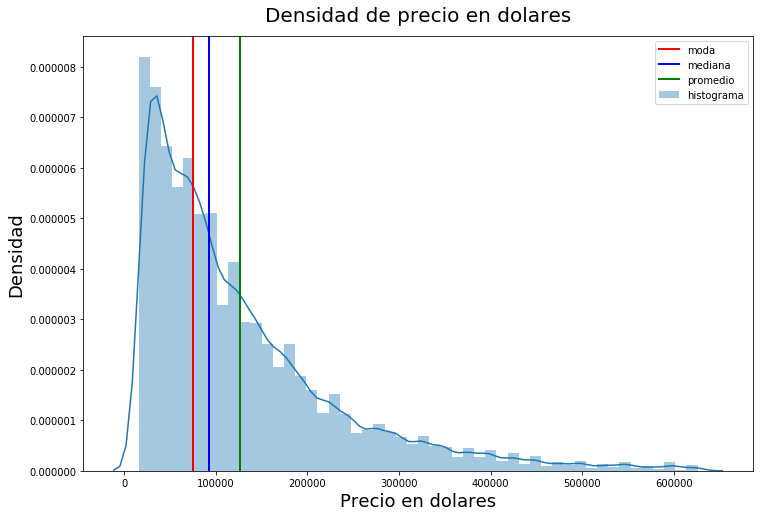

In [45]:
# Plotteamos un density plot para el precio.
mean=df['precio_usd'].mean()
median=df['precio_usd'].median()
mode=df['precio_usd'].mode().get_values()[0]
asimetria_Pearson = ((mean-mode)/df['precio_usd'].std()).round(2)
#print(asimetria_Pearson)


plt.figure(figsize=(12,8))
ax_hist = sns.distplot(df['precio_usd'],)
ax_hist.axvline(mode, color='r', linestyle='-',lw=2)
ax_hist.axvline(median, color='b', linestyle='-',lw=2)
ax_hist.axvline(mean, color='g', linestyle='-',lw=2)
ax_hist.legend(['moda','mediana','promedio','histograma'],)
ax_hist.set_title("Densidad de precio en dolares",fontsize=20, y=1.02)
ax_hist.set_xlabel("Precio en dolares",fontsize=18)
ax_hist.set_ylabel("Densidad", fontsize=18)
#plt.savefig('images/density-plot.png')



La primera observación que vemos es, tomando como eje de referencia a la moda, es que a su derecha hay más datos que a su izquierda, es por este detalle que esté, la distribución, sesgada hacia a la derecha. Otro dato interesante es que la mayoría de las observaciones se encuentra por debajo de la media. La existencia de valores extremos muy altos es lo que genera una cola larga y fina hacia la derecha.
Para confirmar el tipo de asimetría de una manera "no visual" calculamos el coeficiente de asimetría de Pearson, 0.48. Como es un número mayor que cero nos confirma nuestra hipótesis: es una distribución con asimetría positiva.
La interpretación rápida que hacemos de este gráfico es que, aproximadamente, el 45% de las propiedades cuestan entre 0 y 75000 dólares y que el resto oscila entre 75000 y 600000. Esto es lo que genera la cola larga, el rango para las propiedades más caras es muy amplio.
El análisis lo hicimos agregando una columna con el precio en dólares, así nos resulta más familiar. De cualquier manera, utilizando la columna con el precio en pesos mexicanos no cambia absolutamente nada.




In [46]:
# Cargo la serie de inflación.
inflacion_mex = pd.read_csv('data/inflacion_mex.csv',names=['fecha','indice'],parse_dates=['fecha'],dtype={'indice':np.float64})
# Cambio de base al ultimo dato.
infla2019 = inflacion_mex['indice'].tail(1).values[0]
inflacion_mex['indice'] = (inflacion_mex['indice']/infla2019)*100
# Elimino el número de día para poder joinear ambos DF.
inflacion_mex['fecha'] = inflacion_mex['fecha'].dt.to_period('M')
df['fecha']= df['fecha'].dt.to_period('M')
df = df.merge(inflacion_mex,how='inner',on='fecha')
df['precio_constantes'] = (df['precio']/df['indice'])*100

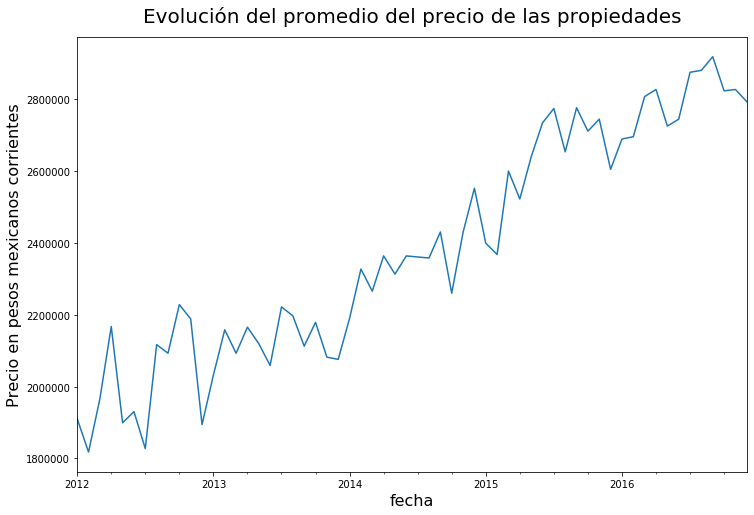

In [47]:
last_price_crte = df.groupby('fecha').precio.mean().tail(1)[0]
first_price_crte = df.groupby('fecha').precio.mean().head(1)[0]
pct_variacion_prop = ((last_price_crte/first_price_crte)-1)*100
#print(pct_variacion_prop)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Evolución del promedio del precio de las propiedades", fontsize=20, y=1.02)
ax.set_ylabel("Precio en pesos mexicanos corrientes", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)


df.groupby('fecha').precio.mean().plot(kind='line')
#plt.savefig("images/evolucion-promedio-precio.png")

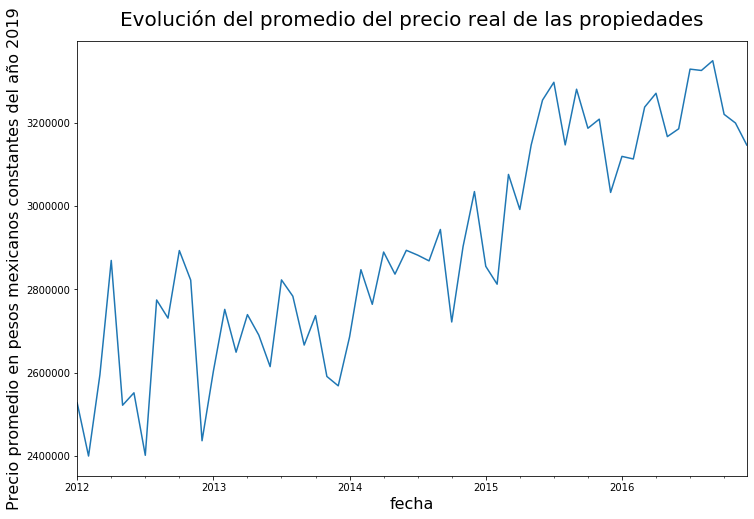

In [48]:
last_price_ctte = df.groupby('fecha').precio_constantes.mean().tail(1)[0]
first_price_ctte = df.groupby('fecha').precio_constantes.mean().head(1)[0]
pct_variacion_prop = ((last_price_ctte/first_price_ctte)-1)*100
#print(pct_variacion_prop)

first_indice = df.sort_values(by='fecha').iloc[0].indice
last_indice = df.sort_values(by='fecha').iloc[-1].indice
pct_variacion_infla = ((last_indice/first_indice)-1)*100
#print(pct_variacion_infla)


fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Evolución del promedio del precio real de las propiedades", fontsize=20, y=1.02)
ax.set_ylabel("Precio promedio en pesos mexicanos constantes del año 2019", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)


serie_precios_reales = df.groupby('fecha').precio_constantes.mean().plot()

#plt.savefig("images/evolucion-precios-reales.png")


### Ruido en Latitud y Longitud

In [49]:
states_data = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
countries_data = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')

In [50]:
mex_states = gpd.read_file(states_data,encoding='utf-8')
world = gpd.read_file(countries_data,enconding='utf-8')
mex_states = mex_states.loc[mex_states['admin']=='Mexico']
mex_countrie = world.loc[world['ADMIN']=='Mexico'].geometry
mex_countrie = gpd.GeoDataFrame(mex_countrie)


In [51]:
zonaprop_gpd = df.dropna(subset=['lat','lng'])
zonaprop_gpd = gpd.GeoDataFrame(zonaprop_gpd,geometry=gpd.points_from_xy(zonaprop_gpd.lng,zonaprop_gpd.lat))

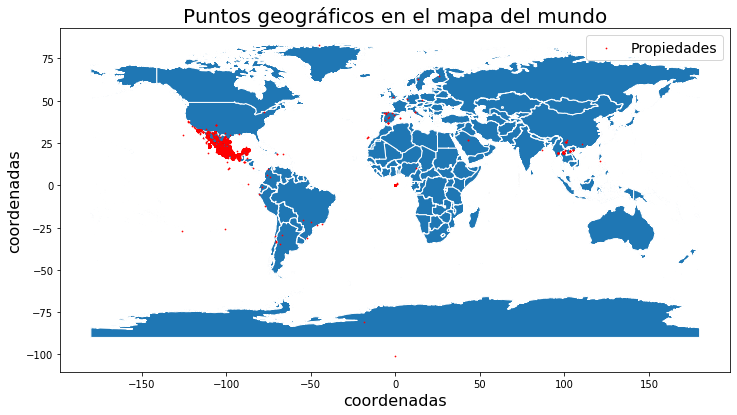

In [52]:
fig, ax = plt.subplots(figsize=(12,8))
world.plot(ax=ax,edgecolor='white')
zonaprop_gpd.plot(color='red',markersize=0.5,ax=ax)
ax.set_title("Puntos geográficos en el mapa del mundo", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
#plt.savefig('images/mapamundi_todos_puntos.png')
plt.show()

In [53]:
puntos_mexico = gpd.sjoin(mex_countrie,zonaprop_gpd,how="right")

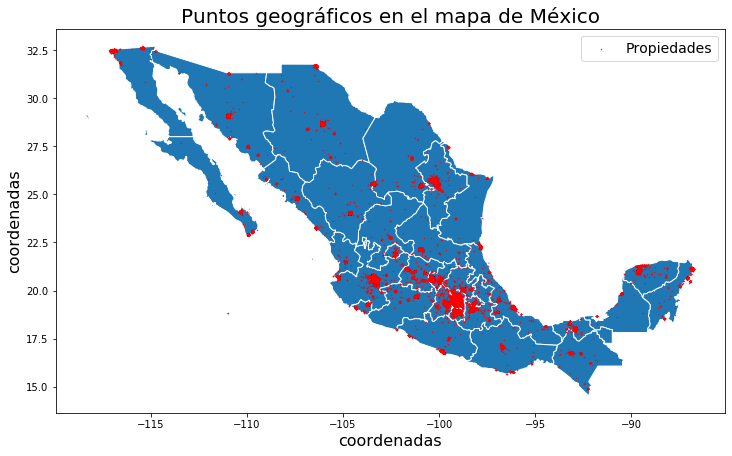

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
mex_states.plot(ax=ax,edgecolor='white')
puntos_mexico.loc[puntos_mexico['index_left']== 155].plot(color='red',markersize=0.2,ax=ax)
ax.set_title("Puntos geográficos en el mapa de México", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
#plt.savefig('images/solo-mexico.png')
plt.show()

In [55]:
poblacion = pd.read_csv('data/poblacion.csv', names=['name_es','poblacion'],encoding='utf-8')
poblacion.name_es = poblacion.name_es.apply(lambda x: x.strip())
poblacion_df = mex_states.merge(poblacion, on='name_es',how="left")
poblacion_df = gpd.GeoDataFrame(poblacion_df)

/home/pintopicada/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(74.625, 0.5, 'coordenadas')

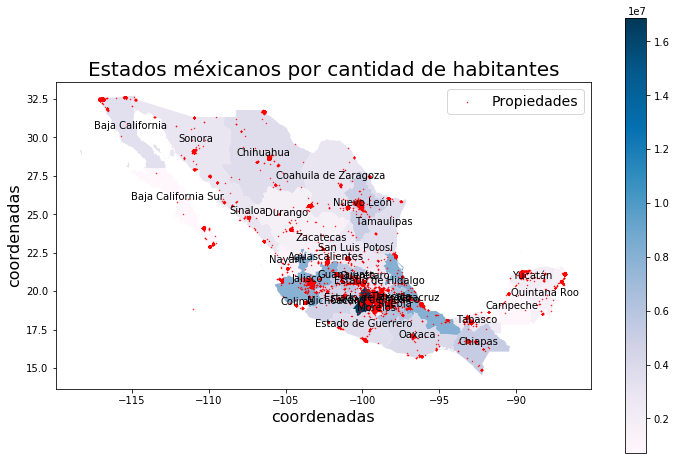

In [56]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))

pb = poblacion_df.plot(column='poblacion',ax=ax, legend= True,cmap='PuBu')
poblacion_df.apply(lambda x: pb.annotate(s=x.name_es, xy=x.geometry.centroid.coords[0], ha='center',color='black'),axis=1)
puntos_mexico.loc[puntos_mexico['index_left']== 155].plot(color='red',markersize=0.2,ax=ax)
ax.set_title("Estados méxicanos por cantidad de habitantes", fontsize=20, y=1.02)
ax.legend(['Propiedades'],prop={'size': 14})
ax.set_xlabel("coordenadas", fontsize=16)
ax.set_ylabel("coordenadas", fontsize=16)
#plt.savefig('images/heatmap-poblacion-y-publicaciones.png',dpi=100)
